In [1]:
import requests
import datetime
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from scipy.optimize import leastsq

import pylab as pl
import math

In [28]:
def to_date(s):
    dt = datetime.datetime.utcfromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d")
def get_visit_list(s):
    data={}
    data['visit_list'] = s['用户ID'].tolist()
    return pd.Series(data)
def get_buy_rate(s):
    data={}
    data['buy_list'] = s['会员ID'].tolist()
    return pd.Series(data)
def get_vip_list(s):
    data={}
    data['vip_list'] = s['id'].tolist()
    return pd.Series(data)
def func(x,p):#函数
    A,B=p
    return A*np.log(x)+B

def residuals(p,y,x):#残差
    ret =y-func(x,p)
    return ret


In [11]:
date = '2019-06-03'
dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [
                                                   {'id': {'terms': {'field': 'id'}}},

                                                  ]}}},
                 'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                              'gte': date,
                                                              'lte': date,
                                                              'time_zone': '+00:00'}}}]}}}
es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res = es.search(index='es_user_table', doc_type='user', body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
df1 = json_normalize(res['aggregations']['my_buckets']['buckets'])
df1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df1.columns))
new_member_list=df1['id'].tolist()

In [12]:
dsl ={'aggs': {'my_buckets': {'aggregations': {},
                             'composite': {'size': 9999999,
                                           'sources': [{'日期': {'date_histogram': {'field': 'paytime',
                                                                                  'interval': '1d',
                                                                                  'time_zone': '+00:00'}}},
                                                       {'会员ID':{'terms':{'field':'user_id'}}},
                                                       ]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=1))[:10], 
                                                        'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=7))[:10], 
                                                         'format': 'yyyy-MM-dd', 'time_zone': '+00:00'}}}, 
                                 {'terms':{'user_id': new_member_list}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}]
                       }}}
es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                search_type='query_then_fetch')
df = json_normalize(res['aggregations']['my_buckets']['buckets'])
df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
df['日期'] = df['日期'].apply(to_date)

df_date=df.groupby('日期').apply(get_buy_rate)

In [13]:
df_date

,buy_list
日期,
2019-06-04,"[561602, 609065, 634628, 690584, 787990, 80951..."
2019-06-05,"[245397, 326659, 391584, 468331, 497092, 60906..."
2019-06-06,"[493785, 497092, 690584, 793954, 799404, 82767..."
2019-06-07,"[326659, 391584, 493785, 584609, 690584, 69176..."
2019-06-08,"[342443, 572517, 584609, 609065, 690584, 73896..."
2019-06-09,"[609065, 690584, 794419, 799404, 809511, 84971..."
2019-06-10,"[493785, 561602, 634628, 690584, 787990, 85169..."


In [14]:
number,percentage=[],[]
for i in range(len(df_date)):
    number.append(len(df_date.iloc[i]['buy_list']))
    percentage.append(len(df_date.iloc[i]['buy_list'])/len(new_member_list))
df_date['人数']=number
df_date['百分比']=percentage

In [15]:
df_date

,buy_list,人数,百分比
日期,,,
2019-06-04,"[561602, 609065, 634628, 690584, 787990, 80951...",46,0.029431
2019-06-05,"[245397, 326659, 391584, 468331, 497092, 60906...",53,0.033909
2019-06-06,"[493785, 497092, 690584, 793954, 799404, 82767...",32,0.020473
2019-06-07,"[326659, 391584, 493785, 584609, 690584, 69176...",20,0.012796
2019-06-08,"[342443, 572517, 584609, 609065, 690584, 73896...",34,0.021753
2019-06-09,"[609065, 690584, 794419, 799404, 809511, 84971...",27,0.017274
2019-06-10,"[493785, 561602, 634628, 690584, 787990, 85169...",25,0.015995


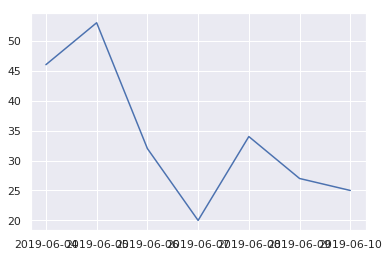

In [17]:
plt.plot(df_date['人数'])

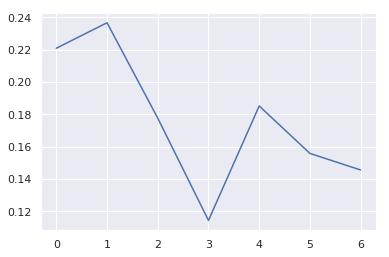

In [18]:
#list_number=[]
#for i in np.log10(df_date['人数']).tolist():
#    list_number.append(np.log10(i))
#plt.plot(list_number)

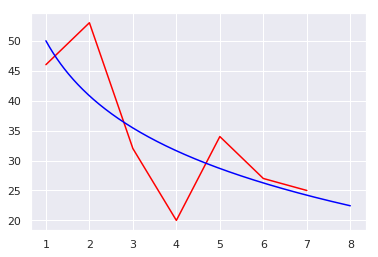

In [32]:
x3=np.linspace(1,8,1000) #用于画图精度的调节
x0=[1,2,3,4,5,6,7] #x变量,
x2=np.array(x0) #向量化x变量
y0=df_date['人数'].tolist()  #y
#y0=np.log10(df_date['人数']).tolist() #y
y2=np.array(y0)#向量化
p0=[1,50]#取值起始点
 
 
qs=leastsq(residuals,p0,args=(y2,x2)) #最小二乘法
#print (qs[0])      #为最佳的拟合函数参数

pl.plot(x0,y0,label='Real',color='red') #画出实际图像
pl.plot(x3,func(x3,qs[0]),label='sim',color='blue') #预测图像

In [21]:
qs[0]

array([-13.24633838,  49.98959602])

In [23]:
predic = 9
buy_value= (qs[0][0]*np.log(predic)+qs[0][1])
buy_value

20.884415774681898

GMV预测模型

In [54]:
dsl ={'aggs': {'my_buckets': {'aggregations': {'折前GMV': {'sum': {'field': 'skutotal_price'}}},
                             'composite': {'size': 9999999,
                                           'sources': [{'日期': {'date_histogram': {'field': 'paytime',
                                                                                  'interval': '1d',
                                                                                  'time_zone': '+00:00'}}},
                                                       #{'会员ID':{'terms':{'field':'user_id'}}},
                                                       ]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=1))[:10],
                                                        'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=9))[:10], 
                                                         'format': 'yyyy-MM-dd', 'time_zone': '+00:00'}}}, 
                                 {'terms':{'user_id': new_member_list}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}]
                       }}}
es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                search_type='query_then_fetch')
df = json_normalize(res['aggregations']['my_buckets']['buckets'])
df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
df['日期'] = df['日期'].apply(to_date)
df

,doc_count,日期,折前GMV.value
0,62,2019-06-05,1634.299998
1,33,2019-06-06,1336.799995
2,25,2019-06-07,1455.099998
3,36,2019-06-08,1458.609999
4,32,2019-06-09,1128.690000
5,28,2019-06-10,1136.300000
6,35,2019-06-11,1825.500000
7,34,2019-06-12,1454.200000
8,37,2019-06-13,1555.889999


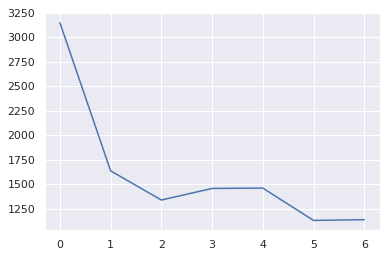

In [25]:
plt.plot(df['折前GMV.value'])

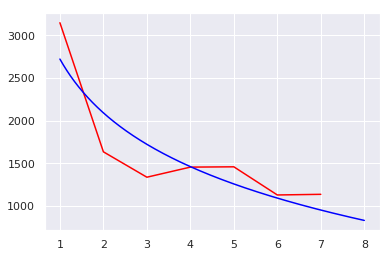

In [34]:
x3=np.linspace(1,8,1000) #用于画图精度的调节
x0=[1,2,3,4,5,6,7] #x变量, 在这里2,3,7全部减1
x2=np.array(x0) #向量化x变量
y0=df['折前GMV.value'].tolist() #y
y2=np.array(y0)#向量化
p0=[1,2800]#取值起始点
 
 
qs=leastsq(residuals,p0,args=(y2,x2)) #最小二乘法
#print (qs[0])      #为最佳的拟合函数参数

pl.plot(x0,y0,label='Real',color='red') #画出实际图像
pl.plot(x3,func(x3,qs[0]),label='sim',color='blue') #预测图像

In [29]:
predic = 8
GMV_value= qs[0][0]*np.log(predic)+qs[0][1]
GMV_value

830.5375305772841

封装函数

In [35]:
def predict_next_day_pop(date):
    dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [
                                                   {'id': {'terms': {'field': 'id'}}},

                                                  ]}}},
                 'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                              'gte': date,
                                                              'lte': date,
                                                              'time_zone': '+00:00'}}}]}}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_user_table', doc_type='user', body=dsl,
                            _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                            search_type='query_then_fetch')
    df1 = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df1.columns))
    new_member_list=df1['id'].tolist()
    dsl ={'aggs': {'my_buckets': {'aggregations': {'折前GMV': {'sum': {'field': 'skutotal_price'}}},
                             'composite': {'size': 9999999,
                                           'sources': [{'日期': {'date_histogram': {'field': 'paytime',
                                                                                  'interval': '1d',
                                                                                  'time_zone': '+00:00'}}},
                                                       {'会员ID':{'terms':{'field':'user_id'}}},
                                                       ]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=1))[:10],  
                                                        'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=7))[:10], 
                                                         'format': 'yyyy-MM-dd', 'time_zone': '+00:00'}}}, 
                                 {'terms':{'user_id': new_member_list}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}]
                       }}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                    search_type='query_then_fetch')
    df = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
    df['日期'] = df['日期'].apply(to_date)

    df_date=df.groupby('日期').apply(get_buy_rate)
    
    number=[]
    for i in range(len(df_date)):
        number.append(len(df_date.iloc[i]['buy_list']))
    df_date['人数']=number


    x3=np.linspace(1,8,1000) #用于画图精度的调节
    x0=[1,2,3,4,5,6,7] #x变量, 在这里2,3,7全部减1
    x2=np.array(x0) #向量化x变量
    y0=df_date['人数'].tolist() #y
    #y0=np.log10(df_date['人数']).tolist() #y
    y2=np.array(y0)#向量化
    p0=[1,2800]#取值起始点

    qs=leastsq(residuals,p0,args=(y2,x2)) #最小二乘法
    
    return qs,pl.plot(x0,y0,label='Real',color='red'),pl.plot(x3,func(x3,qs[0]),label='sim',color='blue') #预测图像
    

In [36]:
def predict_next_day_GMV(date):
    dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [
                                                   {'id': {'terms': {'field': 'id'}}},

                                                  ]}}},
                 'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                              'gte': date,
                                                              'lte': date,
                                                              'time_zone': '+00:00'}}}]}}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_user_table', doc_type='user', body=dsl,
                            _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                            search_type='query_then_fetch')
    df1 = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df1.columns))
    new_member_list=df1['id'].tolist()
    
    dsl ={'aggs': {'my_buckets': {'aggregations': {'折前GMV': {'sum': {'field': 'skutotal_price'}}},
                             'composite': {'size': 9999999,
                                           'sources': [{'日期': {'date_histogram': {'field': 'paytime',
                                                                                  'interval': '1d',
                                                                                  'time_zone': '+00:00'}}},
                                                       #{'会员ID':{'terms':{'field':'user_id'}}},
                                                       ]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=1))[:10],
                                                        'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=7))[:10], 
                                                         'format': 'yyyy-MM-dd', 'time_zone': '+00:00'}}}, 
                                 {'terms':{'user_id': new_member_list}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}]
                       }}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                    search_type='query_then_fetch')
    df = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
    df['日期'] = df['日期'].apply(to_date)

    x3=np.linspace(1,8,1000) #用于画图精度的调节
    x0=[1,2,3,4,5,6,7] #x变量, 
    x2=np.array(x0) #向量化x变量
    y0=df['折前GMV.value'].tolist() #y
    y2=np.array(y0)#向量化
    p0=[1,4.5]#取值起始点
    
    qs=leastsq(residuals,p0,args=(y2,x2)) #最小二乘法
    #print (qs[0])      #为最佳的拟合函数参数
 
    return qs,pl.plot(x0,y0,label='Real',color='red'),pl.plot(x3,func(x3,qs[0]),label='sim',color='blue') #预测图像

In [37]:
def reality_eight_value(date):
    dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [{'id': {'terms': {'field': 'id'}}}]}}},
                 'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd','gte': date,'lte': date,'time_zone': '+00:00'}}}]}}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_user_table', doc_type='user', body=dsl,
                            _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                            search_type='query_then_fetch')
    df1 = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df1.columns))
    new_member_list=df1['id'].tolist()
    dsl ={'aggs': {'my_buckets': {'aggregations': {'折前GMV': {'sum': {'field': 'skutotal_price'}}},
                             'composite': {'size': 9999999,
                                           'sources': [#{'日期': {'date_histogram': {'field': 'paytime',
                                                       #                           'interval': '1d',
                                                       #                           'time_zone': '+00:00'}}},
                                                       {'会员ID':{'terms':{'field':'user_id'}}},
                                                       ]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=8))[:10],
                                                        'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=8))[:10], 
                                                         'format': 'yyyy-MM-dd', 'time_zone': '+00:00'}}}, 
                                 {'terms':{'user_id': new_member_list}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}]
                       }}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                    search_type='query_then_fetch')
    df = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
    pop = len(df)
    GMV_real = df['折前GMV.value'].sum()
    return pop,GMV_real

((array([-13.24633819,  49.98959578]), 1),
 [<matplotlib.lines.Line2D at 0x7f933db5f7b8>])

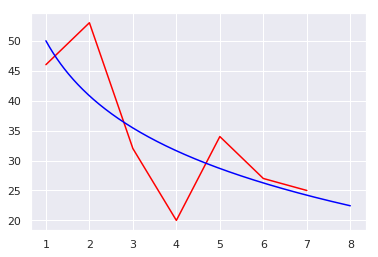

In [117]:
date = '2019-06-03'
predict_next_day_pop(date)

830.5375305772841

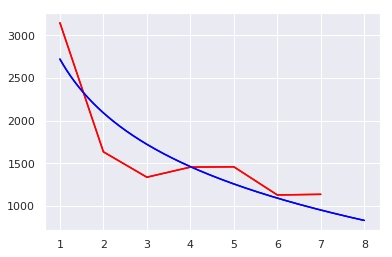

In [119]:
new_day=8
predict_GMV=predict_next_day_GMV(date)[0][0][0]*np.log(new_day)+predict_next_day_GMV(date)[0][0][1]
predict_GMV

In [120]:
reality_eight_value(date)

(31, 1825.5000002384186)

In [121]:
diff_pop=(reality_eight_value(date)[0]-predict_pop)/reality_eight_value(date)[0]
diff_pop

0.2759803263552219

In [122]:
diff_GMV=(reality_eight_value(date)[1]-predict_GMV)/reality_eight_value(date)[1]
diff_GMV

0.5450355899924337

切片

In [56]:
dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [{'日期': {'date_histogram': {'field': 'first_vip_created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+00:00'}}},
                                                   {'id': {'terms': {'field': 'id'}}},

                                                  ]}}},
                 'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                              'gte': '2019-03-01',
                                                              'lte': '2019-06-04',
                                                              'time_zone': '+00:00'}}}]}}}
es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res = es.search(index='es_user_table', doc_type='user', body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
df1 = json_normalize(res['aggregations']['my_buckets']['buckets'])
df1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df1.columns))
df1['日期']= df1['日期'].apply(to_date)
#new_member_list=df1['id'].tolist()

In [57]:
dts=df1.groupby('日期').apply(get_vip_list).reset_index()

In [58]:
GMV_1,GMV_2,GMV_3,GMV_4,GMV_5,GMV_6,GMV_7,GMV_8,GMV_9,GMV_10,GMV_11,GMV_12,GMV_13,GMV_14=[],[],[],[],[],[],[],[],[],[],[],[],[],[]
bar = progressbar
for i in bar.progressbar(range(len(dts))):
    date=dts.iloc[i]['日期']
    dsl ={'aggs': {'my_buckets': {'aggregations': {'折前GMV': {'sum': {'field': 'skutotal_price'}}},
                             'composite': {'size': 9999999,
                                           'sources': [{'日期': {'date_histogram': {'field': 'paytime',
                                                                                  'interval': '1d',
                                                                                  'time_zone': '+00:00'}}},
                                                       ]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=1))[:10],
                                                        'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=14))[:10], 
                                                         'format': 'yyyy-MM-dd', 'time_zone': '+00:00'}}}, 
                                 {'terms':{'user_id': dts.iloc[i]['vip_list']}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}]
                       }}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                    search_type='query_then_fetch')
    df = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
    GMV_1.append(df.iloc[0]['折前GMV.value'])
    GMV_2.append(df.iloc[1]['折前GMV.value'])
    GMV_3.append(df.iloc[2]['折前GMV.value'])
    GMV_4.append(df.iloc[3]['折前GMV.value'])
    GMV_5.append(df.iloc[4]['折前GMV.value'])
    GMV_6.append(df.iloc[5]['折前GMV.value'])
    GMV_7.append(df.iloc[6]['折前GMV.value'])
    GMV_8.append(df.iloc[7]['折前GMV.value'])
    GMV_9.append(df.iloc[8]['折前GMV.value'])
    GMV_10.append(df.iloc[9]['折前GMV.value'])
    GMV_11.append(df.iloc[10]['折前GMV.value'])
    GMV_12.append(df.iloc[11]['折前GMV.value'])
    GMV_13.append(df.iloc[12]['折前GMV.value'])
    GMV_14.append(df.iloc[13]['折前GMV.value'])
    

100% (96 of 96) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


In [59]:
dts['第一天']=GMV_1
dts['第二天']=GMV_2
dts['第三天']=GMV_3
dts['第四天']=GMV_4
dts['第五天']=GMV_5
dts['第六天']=GMV_6
dts['第七天']=GMV_7
dts['第八天']=GMV_8
dts['第九天']=GMV_9
dts['第十天']=GMV_10
dts['第十一天']=GMV_11
dts['第十二天']=GMV_12
dts['第十三天']=GMV_13
dts['第十四天']=GMV_14

In [61]:
sum_1=dts['第一天'].sum()/len(dts)
sum_2=dts['第二天'].sum()/len(dts)
sum_3=dts['第三天'].sum()/len(dts)
sum_4=dts['第四天'].sum()/len(dts)
sum_5=dts['第五天'].sum()/len(dts)
sum_6=dts['第六天'].sum()/len(dts)
sum_7=dts['第七天'].sum()/len(dts)
sum_8=dts['第八天'].sum()/len(dts)
sum_9=dts['第九天'].sum()/len(dts)
sum_10=dts['第十天'].sum()/len(dts)
sum_11=dts['第十一天'].sum()/len(dts)
sum_12=dts['第十二天'].sum()/len(dts)
sum_13=dts['第十三天'].sum()/len(dts)
sum_14=dts['第十四天'].sum()/len(dts)

In [62]:
all_list=[sum_1,sum_2,sum_3,sum_4,sum_5,sum_6,sum_7,sum_8,sum_9,sum_10,sum_11,sum_12,sum_13,sum_14]

([<matplotlib.lines.Line2D at 0x7f6199d5ec50>],
 [<matplotlib.lines.Line2D at 0x7f6199d5e1d0>])

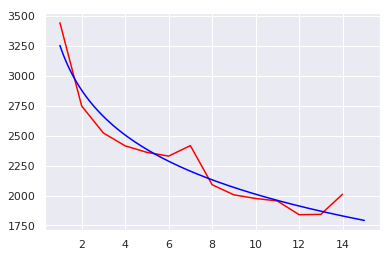

In [63]:
x3=np.linspace(1,15,1000) #用于画图精度的调节
x0=[1,2,3,4,5,6,7,8,9,10,11,12,13,14] #x变量, 
x2=np.array(x0) #向量化x变量
y0=all_list #y
y2=np.array(y0)#向量化
p0=[1,3000]#取值起始点
    
qs=leastsq(residuals,p0,args=(y2,x2)) #最小二乘法
pl.plot(x0,y0,label='Real',color='red'),pl.plot(x3,func(x3,qs[0]),label='sim',color='blue') #预测图像